In [36]:
import pandas as pd
import seaborn as sns
import numpy as np

In [37]:
BUCKET_PATH="gs://fc-80261891-d43b-4aeb-b868-3b7489d0ebf9/gvs/analysis2"
!gsutil cp {BUCKET_PATH}/* .

Copying gs://fc-80261891-d43b-4aeb-b868-3b7489d0ebf9/gvs/analysis2/10k.original.intervals.summary.txt...
Copying gs://fc-80261891-d43b-4aeb-b868-3b7489d0ebf9/gvs/analysis2/10k.original.op.details.txt...
Copying gs://fc-80261891-d43b-4aeb-b868-3b7489d0ebf9/gvs/analysis2/10k.original.task.info.txt...
/ [3 files][665.6 KiB/665.6 KiB]                                                
Operation completed over 3 objects/665.6 KiB.                                    


In [38]:
def get_data(prefix):

    df = pd.read_csv(f"{prefix}.task.info.txt", 
                 sep='\t', 
                 names=['index', 'attempt', 'preemptible', 'execution_status', 'start', 'end', 'full_op_id'], 
                 header=None,
                 parse_dates=['start','end']) 

    odf = pd.read_csv(f"{prefix}.op.details.txt", 
                 sep='\t', 
                 names=['full_op_id', 'start', 'end'], 
                 header=None,
                 parse_dates=['start','end'])

    odf = odf[ odf['end'].notnull() ]
    odf = odf[ odf['end'] != 'None' ]
    odf.sort_values(by=['start']).tail()
    odf['start'] = pd.to_datetime(odf['start'])
    odf['end'] = pd.to_datetime(odf['end'])


    df['elapsed'] = (df['end'] - df['start']).astype('timedelta64[m]')
    odf['elapsed'] = (odf['end'] - odf['start']).astype('timedelta64[m]')

    intervals = pd.read_csv(f"{prefix}.intervals.summary.txt", 
                 sep='\t')

    x = df.merge(odf, how='left', on='full_op_id', suffixes=('', '_papi'))
    x = x.merge(intervals, how='left', on='index', suffixes=('', '_interval'))
    x = x[ x['execution_status'] == 'Done']
    
    return x

In [40]:
d = get_data("10k.original")
d['run'] = 'Original'

# used for comparing to a post-balancing run
#b = get_data("10k.balanced")
#b['run'] = 'Balanced'
#d = d.append(b, ignore_index=True)

d = d[ d['execution_status'] == 'Done' ]

d['type'] = "autosome"
d.loc[d.contig == 'chrX', 'type'] = "chrX"
d.loc[d.contig == 'chrY', 'type'] = "chrY"


<AxesSubplot:xlabel='elapsed_papi', ylabel='Count'>

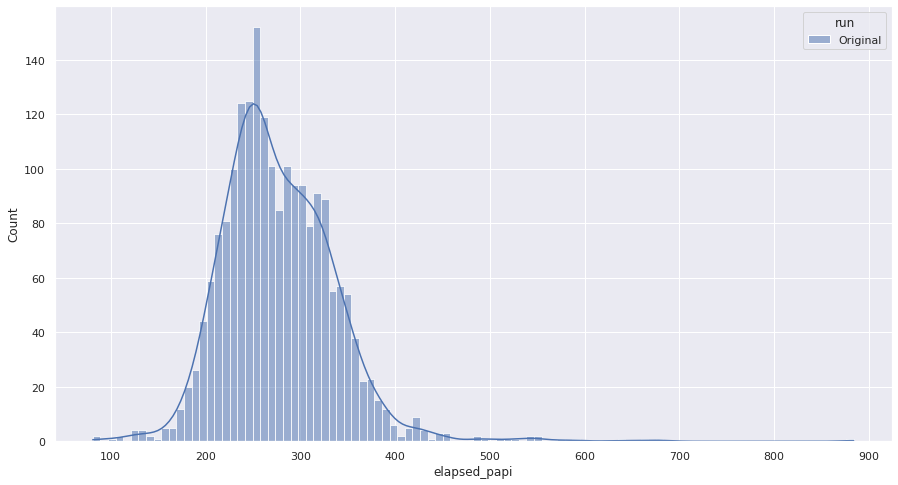

In [41]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.histplot(data=d, x="elapsed_papi", hue="run", kde=True, bins=100 )


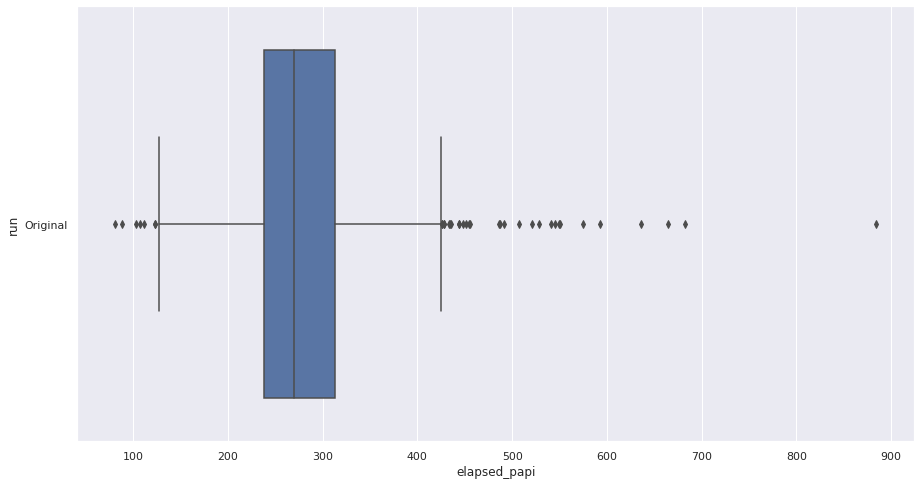

In [42]:
ax = sns.boxplot(y="run", x="elapsed_papi", data=d, orient="h")

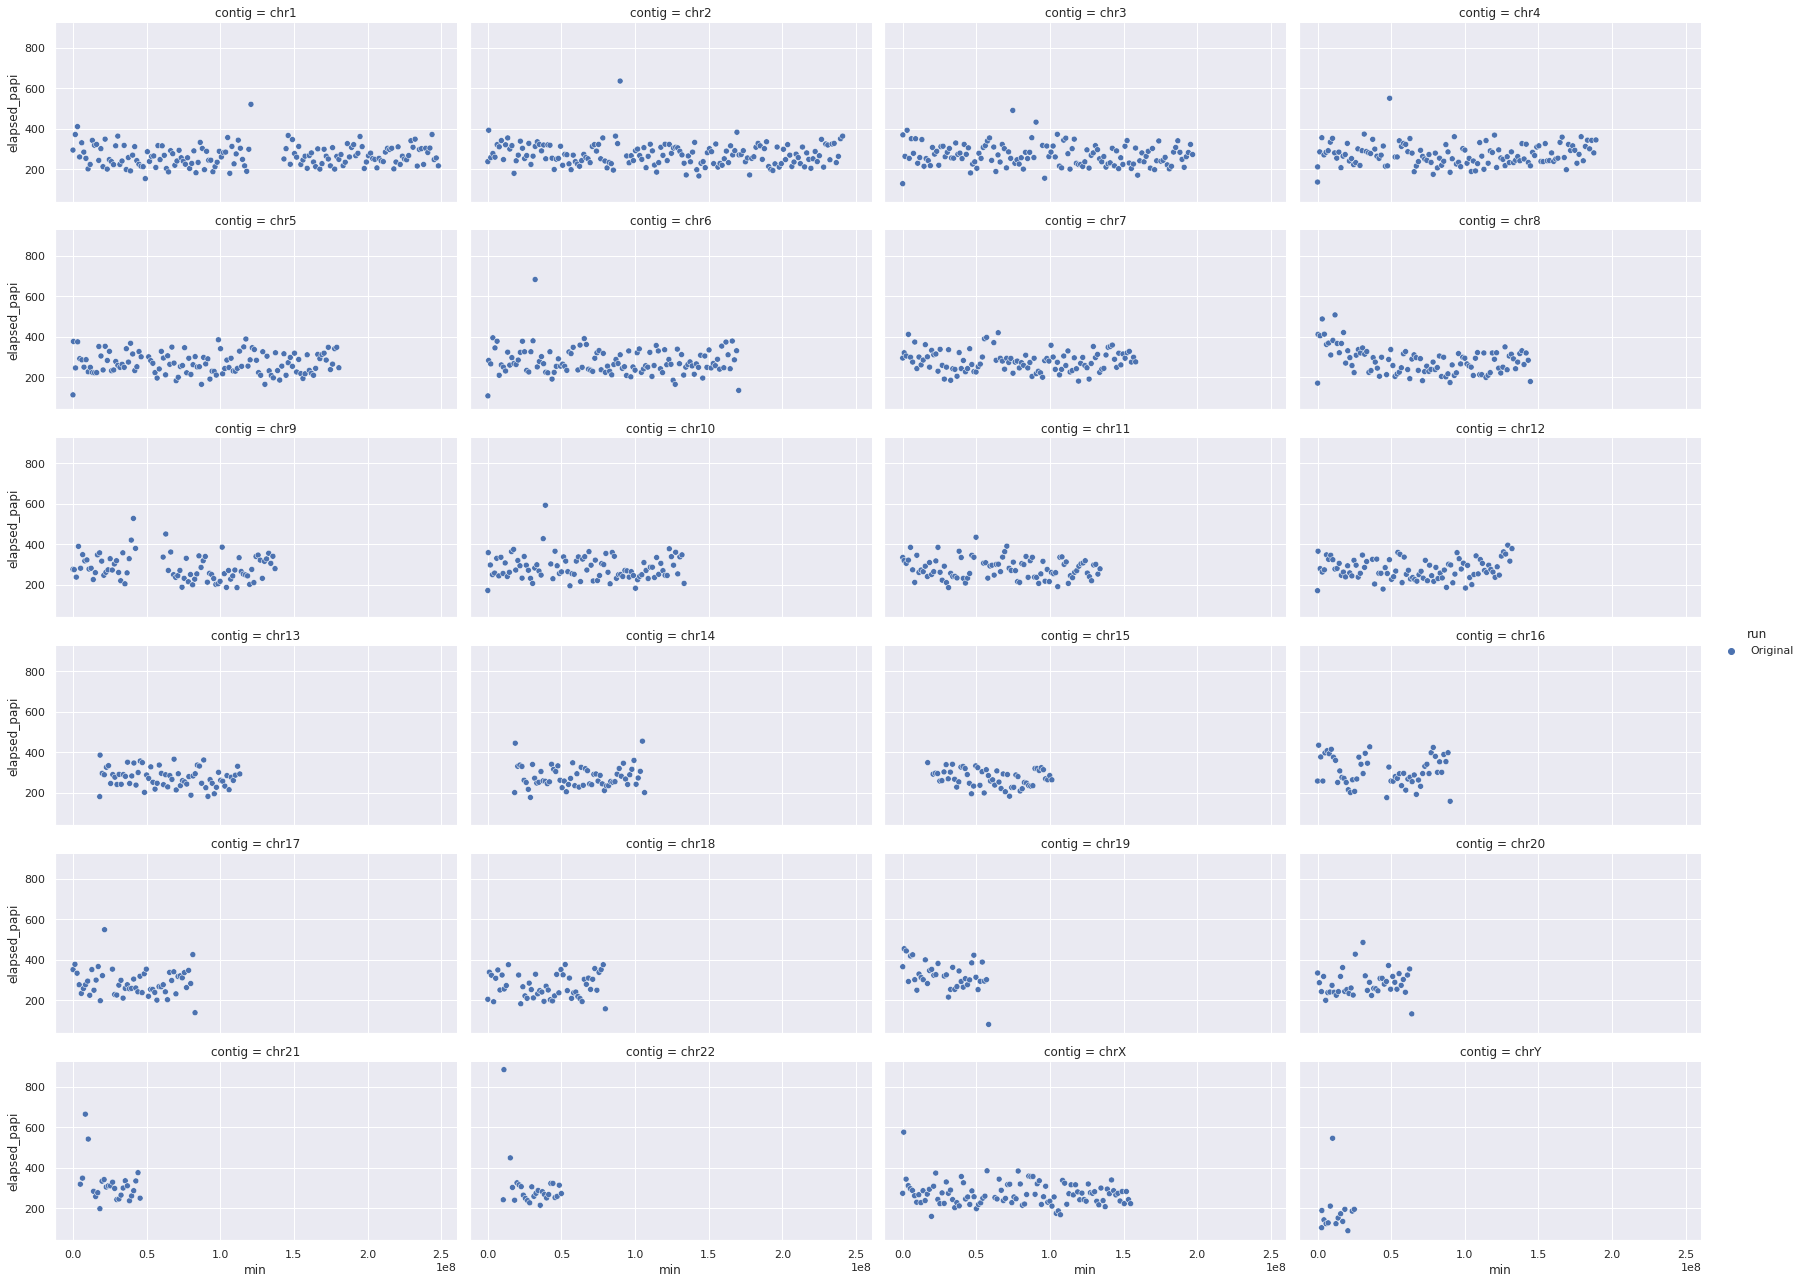

In [43]:
sns.set(rc={'figure.figsize':(15,8)})
sns.relplot(
    data=d, x="min", y="elapsed_papi",
    height=3, aspect=2,
    col="contig", col_wrap=4, hue="run",
    kind="scatter"
)

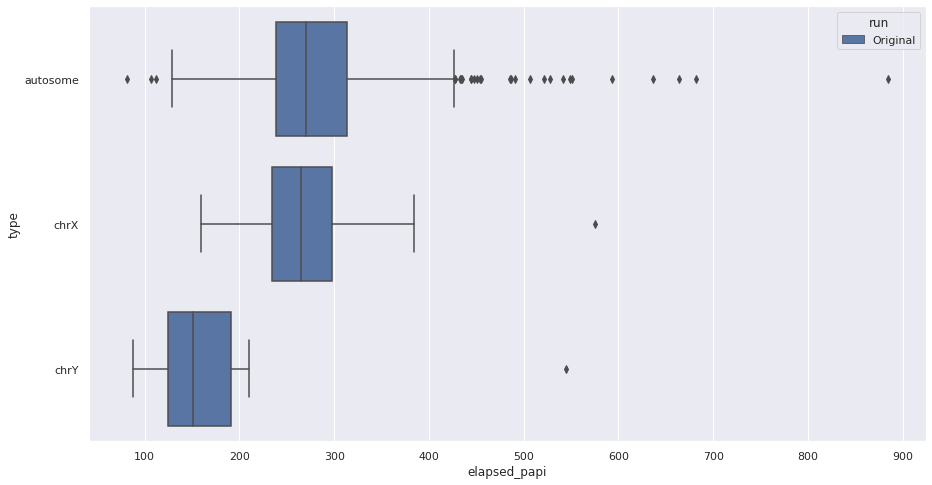

In [44]:
ax = sns.boxplot(y="type", x="elapsed_papi", hue="run", data=d, orient="h")